# Проект для «Викишоп»

Интернет-магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Задача построить модель со значением метрики качества *F1* не меньше 0.75. 

**План проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделайть выводы.

## Подготовка

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import nltk

# лемматизатор
from nltk.corpus import wordnet
import sys
import spacy

# стоп-слова
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# модели и метрики
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

# предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
display('Количетсво пропусков по каждому столбцу:', df.isna().sum())

'Количетсво пропусков по каждому столбцу:'

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [5]:
display('Количество дубликатов:', df.duplicated().sum())

'Количество дубликатов:'

0

In [6]:
pd.set_option('display.max_colwidth', None)

In [7]:
df.head(10)

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,9,alignment on this subject and which are contrary to those of DuLithgow,0


In [8]:
df.tail(5)

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0
159288,159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159290,159449,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0
159291,159450,"""\nAnd ... I really don't think you understand. I came here and my idea was bad right away. What kind of community goes """"you have bad ideas"""" go away, instead of helping rewrite them. """,0


**Посмотрим на баланс классов**

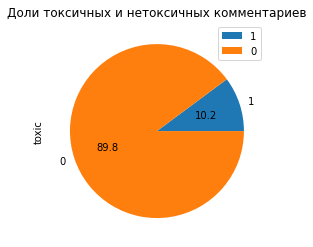

0    143106
1     16186
Name: toxic, dtype: int64

In [9]:
df['toxic'].value_counts(ascending=True).plot.pie(autopct="%.1f")
plt.title("Доли токсичных и нетоксичных комментариев")
plt.legend()
plt.show()
df['toxic'].value_counts()

- В датасете присутствуют 159292 объекта, столбец с комментариями ('text') и целевой признак ('toxic') с где указаны токсичные комментарии значением 1. Комментарии на английском языке.
- Пропущенных значений и дубликатов нет.
- Доля токсичных комментариев составляет 10,2% от всего датасета, виден явный дисбаланс классов.
- В комментариях замечены знаки \n, :, ", # и так далее.
- Необходимо лемматизировать текст и удалить лишние знаки.
- В столбце Unnamed приведен порядковый номер комментария. при этом последний номер больше чем количество объектов, вероятно часть сообщений было удалено из датасета. Данный столбец можно удалить.

In [10]:
df = df.drop(['Unnamed: 0'], axis=1)

In [11]:
df.head(10)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,alignment on this subject and which are contrary to those of DuLithgow,0


In [12]:
#создадим функцию для очистки текста от ненужных знаков.
def clear_text(text):     
    text = " ".join(re.sub(r"(?!')[\W\d]+|(?![\w])' ", ' ', text).split()).lower()       
    return text

In [13]:
df['text'] = df['text'].apply(clear_text)

In [14]:
df.head(10)

,text,toxic
0,explanation why the edits made under my username hardcore metallica fan were reverted they weren't vandalisms just closure on some gas after i voted at new york dolls fac and please don't remove the template from the talk page since i'm retired now,0
1,d'aww he matches this background colour i'm seemingly stuck with thanks talk january utc,0
2,hey man i'm really not trying to edit war it's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0
3,more i can't make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it's listed in the relevant form eg wikipedia good_article_nominations transport,0
4,you sir are my hero any chance you remember what page that's on,0
5,congratulations from me as well use the tools well talk,0
6,cocksucker before you piss around on my work,1
7,your vandalism to the matt shirvington article has been reverted please don't do it again or you will be banned,0
8,sorry if the word nonsense was offensive to you anyway i'm not intending to write anything in the article wow they would jump on me for vandalism i'm merely requesting that it be more encyclopedic so one can use it for school as a reference i have been to the selective breeding page but it's almost a stub it points to animal breeding which is a short messy article that gives you no info there must be someone around with expertise in eugenics,0
9,alignment on this subject and which are contrary to those of dulithgow,0


**Библиотеки для лемматизации pymorphy2, UDPipe, pymystem3 предназначены для русского текста. Для английского текста будем использовать лемматизатор spaCy (ссылка на статью: https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/).**

In [15]:
# сначала проверим метод
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
sentence = "The striped bats are hanging on their feet for best"
doc = nlp(sentence)
" ".join([token.lemma_ for token in doc])


'the stripe bat be hang on their foot for good'

In [16]:
# создадим функцию лемматизации на основе spaCy
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [17]:
tqdm.pandas()

#лемматизируем текст и запишем его в отдельный столбец 'lemm_text'

df['lemm_text'] = df['text'].progress_apply(lemmatize)

100%|██████████| 159292/159292 [14:44<00:00, 180.14it/s]


In [18]:
#Выделим признак и целевой признак
features = df['lemm_text']
target = df['toxic']

In [19]:
#зафиксируем random_state
RS = 12345

In [20]:
#Разделим на датасет на обучающую и тестовую выборки
features_train_not_tf_idf, features_test_not_tf_idf, target_train, target_test  = train_test_split(features, 
                                                                                 target, 
                                                                                 test_size=0.25,
                                                                                 stratify=target,
                                                                                 random_state=RS)
print(features_train_not_tf_idf.shape)
print(target_train.shape)
print(features_test_not_tf_idf.shape)
print(target_test.shape)

(119469,)
(119469,)
(39823,)
(39823,)


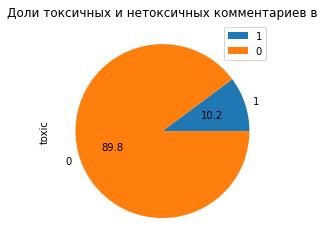

0    107329
1     12140
Name: toxic, dtype: int64

In [21]:
target_train.value_counts(ascending=True).plot.pie(autopct="%.1f")
plt.title("Доли токсичных и нетоксичных комментариев в")
plt.legend()
plt.show()
target_train.value_counts()

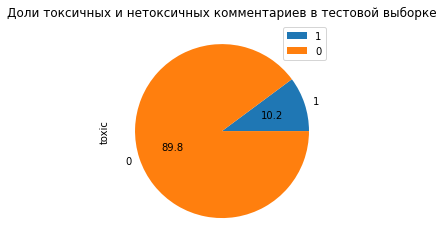

0    35777
1     4046
Name: toxic, dtype: int64

In [22]:
target_test.value_counts(ascending=True).plot.pie(autopct="%.1f")
plt.title("Доли токсичных и нетоксичных комментариев в тестовой выборке")
plt.legend()
plt.show()
target_test.value_counts()

**Выборка поделена грамотно с учетом дисбаланса классов, применен параметр stratify=target.**

In [23]:
# загрузим стоп-слова
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# создадим счётчик величин TF-IDF, указав в нём стоп-слова
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [25]:
#Вычислим TF-IDF для корпуса текстов

features_train = count_tf_idf.fit_transform(features_train_not_tf_idf)
features_test = count_tf_idf.transform(features_test_not_tf_idf)
print(features_train.shape)
print(features_test.shape)

(119469, 133162)
(39823, 133162)


In [26]:
# Зафиксируем генератор кросс-валидации cv
MY_CV = 3

**Вывод:**
- Выполнена очистка и лемматизация текста средствами spaCy.
- Выделен признак и целевой признак в отдельные переменые.
- Данные разбиты на обучающую и тестовую выборку с учетом дисбаланса классов.
- Вычислен TF-IDF для корпуса текстов значения занесены в качестве признака.

## Обучение

**Обучение всех моделей будем проводить сразу со взвешиванием классов, так как обычно это дает хороший результат.**

**2.1. Обучим модель линейной регрессии.**

In [27]:
parameters_log = [{'C':[0.1, 1, 10],
                'penalty':['l1', 'l2', 'elasticnet']}]

In [28]:
%%time
model_log = LogisticRegression(random_state=RS, class_weight='balanced', solver='liblinear')
grid_log = GridSearchCV(model_log, parameters_log, cv=MY_CV, scoring='f1')
grid_log.fit(features_train, target_train)

CPU times: user 1min 26s, sys: 1min 18s, total: 2min 45s
Wall time: 2min 45s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=12345,
                                          solver='liblinear'),
             param_grid=[{'C': [0.1, 1, 10],
                          'penalty': ['l1', 'l2', 'elasticnet']}],
             scoring='f1')

In [29]:
best_parameters_log = grid_log.best_params_
best_score_log = round(grid_log.best_score_, 2)
print('Лучшие гиперпараметры для логистической регрессии:', best_parameters_log)
print("'F1-мера' для логистической регрессии:", best_score_log)

Лучшие гиперпараметры для логистической регрессии: {'C': 10, 'penalty': 'l2'}
'F1-мера' для логистической регрессии: 0.77


**2.2. Обучим модель случайного леса.**

In [30]:
parameters_forest = {'n_estimators': range(10, 51, 10),
                     'max_depth': range(1, 10), 
                     'min_samples_leaf': range(1,6)}

In [31]:
%%time
model_forest = RandomForestClassifier(random_state=RS, class_weight='balanced')
grid_forest = GridSearchCV(model_forest, parameters_forest, cv=MY_CV, scoring='f1')
grid_forest.fit(features_train, target_train)

CPU times: user 23min 59s, sys: 18.2 s, total: 24min 17s
Wall time: 24min 18s


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 6),
                         'n_estimators': range(10, 51, 10)},
             scoring='f1')

In [32]:
best_parameters_forest = grid_forest.best_params_
best_score_forest = round(grid_forest.best_score_, 2)
print('Лучшие гиперпараметры для модели случайного леса:', best_parameters_forest)
print("'F1-мера' для модели случайного леса:", best_score_forest)

Лучшие гиперпараметры для модели случайного леса: {'max_depth': 4, 'min_samples_leaf': 3, 'n_estimators': 10}
'F1-мера' для модели случайного леса: 0.35


**3.3. Обучим модель CatBoostClassifier.**

In [33]:
parameters_cbc = {'learning_rate': np.logspace(-2, 0, 4),
                  'depth': range(10, 41, 10)}

In [34]:
%%time

model_cbс = CatBoostClassifier(verbose=False, loss_function="Logloss", iterations=10, auto_class_weights='Balanced')
grid_cbc = GridSearchCV(model_cbс, parameters_cbc, scoring='f1', cv=MY_CV)
grid_cbc.fit(features_train, target_train)

CPU times: user 30min 10s, sys: 5.25 s, total: 30min 15s
Wall time: 30min 29s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fa083ceb190>,
             param_grid={'depth': range(10, 41, 10),
                         'learning_rate': array([0.01      , 0.04641589, 0.21544347, 1.        ])},
             scoring='f1')

In [35]:
best_parameters_cbc = grid_cbc.best_params_
best_score_cbc = round(grid_cbc.best_score_, 2)
print('Лучшие гиперпараметры для модели CatBoostClassifier:', best_parameters_cbc)
print("'F1-мера' для модели CatBoostClassifier:", best_score_cbc)

Лучшие гиперпараметры для модели CatBoostClassifier: {'depth': 10, 'learning_rate': 0.21544346900318834}
'F1-мера' для модели CatBoostClassifier: 0.67


In [36]:
#занесем результаты в отдельный датафрейм
model_type = ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier']
f1 = [best_score_log, best_score_forest, best_score_cbc]



result = pd.DataFrame({'Model Type': model_type,
                           'F1-мера': f1})

result

,Model Type,F1-мера
0,LogisticRegression,0.77
1,RandomForestClassifier,0.35
2,CatBoostClassifier,0.67


**Протестирую лучшую модель**

In [37]:
%%time

model_log = LogisticRegression(random_state=RS, class_weight='balanced', solver='liblinear', C=10, penalty='l2')
# model_log = LogisticRegression(random_state=RS, class_weight='balanced', solver='liblinear', best_score_log)

model_log.fit(features_train, target_train)
predictions_test_log = model_log.predict(features_test)
result_log = round(f1_score(target_test, predictions_test_log), 2)

probabilities_test_log = model_log.predict_proba(features_test)
probabilities_one_test_log = probabilities_test_log[:, 1]
auc_roc_log = round(roc_auc_score(target_test, probabilities_one_test_log), 2)
print("'F1-мера' для логистической регрессии на тестовой выборке:", result_log)
print("'AUC-ROC' для логистической регрессии на тестовой выборке:", auc_roc_log)

'F1-мера' для логистической регрессии на тестовой выборке: 0.77
'AUC-ROC' для логистической регрессии на тестовой выборке: 0.97
CPU times: user 12.2 s, sys: 13.9 s, total: 26.1 s
Wall time: 26.2 s


**На тестовой выборке 'F1-мера' для логистической регрессии составила 0,77, что больше необходимого значения (0,75). 'AUC-ROC' составила 0,97.**

**Сравним результаты со случайной моделью с помощью ROC-кривой.**

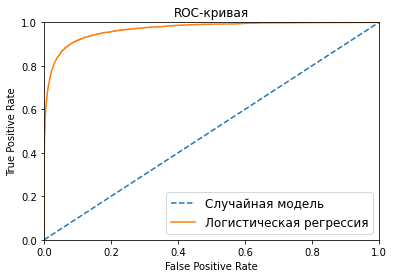

In [38]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_log)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
plt.plot(fpr, tpr, label='Логистическая регрессия')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize='large')
plt.title('ROC-кривая')
plt.show()

**Наша модель прошла тест на адекватность, она лучше случайной модели.**

## Выводы

**В результате анализа общей информации выявлено следующее:**

- В датасете присутствуют 159292 объекта, столбец с комментариями ('text') и целевой признак ('toxic') с где указаны токсичные комментарии значением 1. Комментарии на английском языке.
- Пропущенных значений и дубликатов нет.
- Доля токсичных комментариев составляет 10,2% от всего датасета, виден явный дисбаланс классов.
- В комментариях замечены знаки \n, :, ", # и так далее.
- Необходимо лемматизировать текст и удалить лишние знаки.
- В столбце Unnamed приведен порядковый номер комментария. при этом последний номер больше чем количество объектов, вероятно часть сообщений было удалено из датасета. Данный столбец можно удалить.

**В результате подготовки данных выполнено:**

- Выполнена очистка и лемматизация текста средствами spaCy.
- Выделен признак и целевой признак в отдельные переменые.
- Данные разбиты на обучающую и тестовую выборку с учетом дисбаланса классов.
- Вычислен TF-IDF для корпуса текстов, значения занесены в качестве признака.

**Модели:**
- Обучение всех моделей проведено сразу со взвешиванием классов, так как обычно это дает хороший результат.

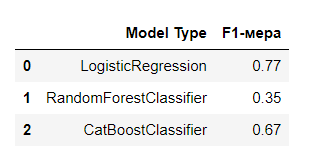

- В результате обучения моделей наилучшей оказалась модель логистической регрессии со следующими гиперпараметрами: {'C': 10, 'penalty': 'l2'}.
- Финальная оценка F1-меры на тестовой выборке составила 0.77, что больше необходимого значения (0,75).
- Модель прошла проверку на адекватность при сравнении со случайной моделью, с помощью ROC-кривой.